In [88]:
import numpy as np
import pandas as pd 
import datetime

# imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Import TFIDFVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

#tokenizers
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

#neural network RNN
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping



#### Merging dataframes 

In [27]:
daily2 = pd.read_csv('/Users/plarkin/Documents/GA/projects/p5/tanveer/Data/oc_daily.csv')
daily2.head(1)


,date,text,day_of_week,is_holiday,Open,Close,Volume
0,2011-07-29,"Drug App Comes Free, Ads Included. Epocrates h...",4,0,1300.119995,1292.280029,5.061190e+09


In [28]:
# to load file 
daily = pd.read_csv('/Users/plarkin/Documents/GA/projects/p5/tanveer/clean_daily_oc.csv')
daily.head(1)

,date,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_holiday_1,Open_pct,Close_pct,Volume_diff,Open_pct_l1,Close_pct_l1,Volume_diff_l1,direction
0,2011-07-31,0,0,0,0,0,1,0,0.0,0.0,0.0,-0.00603,0.0,-5.061190e+09,same


In [29]:
daily.shape,daily2.shape

((3651, 15), (3653, 7))

In [30]:
daily = daily.join(daily2, how ='inner',lsuffix = '_')
daily.head(1)

,date_,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_holiday_1,Open_pct,Close_pct,...,Close_pct_l1,Volume_diff_l1,direction,date,text,day_of_week,is_holiday,Open,Close,Volume
0,2011-07-31,0,0,0,0,0,1,0,0.0,0.0,...,0.0,-5.061190e+09,same,2011-07-29,"Drug App Comes Free, Ads Included. Epocrates h...",4,0,1300.119995,1292.280029,5.061190e+09


In [31]:
daily.columns

Index(['date_', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'is_holiday_1',
       'Open_pct', 'Close_pct', 'Volume_diff', 'Open_pct_l1', 'Close_pct_l1',
       'Volume_diff_l1', 'direction', 'date', 'text', 'day_of_week',
       'is_holiday', 'Open', 'Close', 'Volume'],
      dtype='object')

## Sentiment Analysis

#### Vader Sentiment Analysis

#### Textblob Sentiment Analysis
source : https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

https://textblob.readthedocs.io/en/dev/

In [32]:
#Adding in Sentiment analysis with designated columns for each output (pos, neg, neu, compound)
analyzer = SentimentIntensityAnalyzer()

#daily['vader'] = daily['text'].map(lambda x:analyzer.polarity_scores(str(x)))


daily['vader_compound'] = [analyzer.polarity_scores(x)['compound'] for x in daily['text']]
# draft_df['vd_neg'] = [analyzer.polarity_scores(x)['neg'] for x in draft_df['alltext']]
# draft_df['vd_neu'] = [analyzer.polarity_scores(x)['neu'] for x in draft_df['alltext']]
# draft_df['vd_pos'] = [analyzer.polarity_scores(x)['pos'] for x in draft_df['alltext']]

%time

from textblob import TextBlob
#testimonial = TextBlob()
#draft_df['tb_polarity'] = [testimonial.polarity(x)['polarity'] for x in draft_df['alltext']]
#draft_df['tb_subj'] = [testimonial.sentiment(x)['subjectivity'] for x in draft_df['alltext']]
daily['textblob_polarity'] = daily['text'].map(lambda words: TextBlob(str(words)).polarity) #polarity is more applicable and comparable to vader compound. subjectivity is more about opinion vs fact 

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


### Text Cleaning
eliminate the punctuation, URL, and @
#source: https://monkeylearn.com/blog/text-cleaning/

In [34]:
#Use this to remove http, punctuation, URL, and @
daily['text'] = daily['text'].map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x.lower())))
#convert price_direction to numerical and drop first row with NA value
daily.dropna(inplace=True)
daily['direction'] = daily['direction'].map({'down' : -1,'same' : 0 , 'up' : 1})

tokenize and lemmatize
(no longer lemmatizing, results from gridsearch showed superior accuracy without lemmatizing)

# Checking w/out tokenizing

In [35]:
#for checking model with just sentiment
merged_df = daily

In [47]:
#setting date as index and dropping text column for modeling
merged_df.set_index('date', inplace=True)
merged_df.sort_index(inplace=True)
merged_df.drop(columns= ['text', 'day_of_week','date_'], inplace=True)


KeyError: "None of ['date'] are in the columns"

### Train Test Split

In [51]:
X= merged_df.drop(columns=['Open_pct','Close_pct','Volume_diff','direction'])
y=merged_df['direction']

# X = merged_df.drop(columns= ['price_direction'])
# y = merged_df[['price_direction']].values
# yy = merged_df['price_direction']


In [68]:
yy.value_counts(normalize=True)

 1    0.380992
-1    0.311148
 0    0.307861
Name: price_direction, dtype: float64

In [66]:
#sticking with a test size of 0.20 to save 2 years of data to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)


In [67]:
#need to one hot encode multiclass target in order to process in nn
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

#source https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible

In [68]:
# Scale for neural networks
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [69]:
# the length parameter dictates how many rows will constitute a sample
train_sequences = TimeseriesGenerator(Xs_train, y_train, length=90, batch_size=268) #increased batch sizes from 64 to 268
# test sequences
test_sequences = TimeseriesGenerator(Xs_test, y_test, length=90, batch_size=268)

In [70]:
train_sequences[0][0].shape

(268, 90, 16)

In [71]:
input_shape = train_sequences[0][0][0].shape
input_shape

(90, 16)

# RNN 
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [83]:
# model network 

rnn3 = Sequential()

rnn3.add(GRU(8,input_shape=input_shape, return_sequences=True))
rnn3.add(GRU(8,return_sequences=True))
rnn3.add(GRU(8,return_sequences=False)) # false if next layer dense

rnn3.add(Dense(10,activation='relu'))
rnn3.add(Dense(10,activation='relu'))

rnn3.add(Dense(3,activation='softmax'))

# compile model 
rnn3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# show summary 
rnn3.summary()

hist_rnn3 = rnn3.fit(train_sequences,validation_data=test_sequences,
                  epochs=100,verbose=0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, 90, 8)             624       
_________________________________________________________________
gru_20 (GRU)                 (None, 90, 8)             432       
_________________________________________________________________
gru_21 (GRU)                 (None, 8)                 432       
_________________________________________________________________
dense_23 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 33        
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
____________________________________________________

In [79]:
# helper function to plot train and val accuracy 
def plot_acc(hist):
    plt.plot(hist.history['acc'], label='Train accuracy')
    plt.plot(hist.history['val_acc'], label='Test accuracy')
    plt.legend();

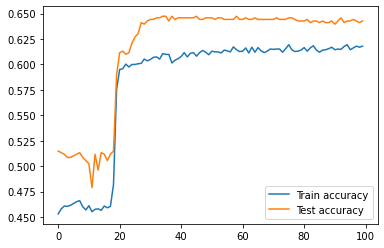

In [84]:
plot_acc(hist_rnn3)

In [72]:
#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(3, activation='softmax'))

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc'])

#fit it
#adding early stopping as a regularization technique
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(train_sequences, validation_data=test_sequences, epochs=100, verbose=0, callbacks=[early_stop]) #increased epochs from 100 to 300


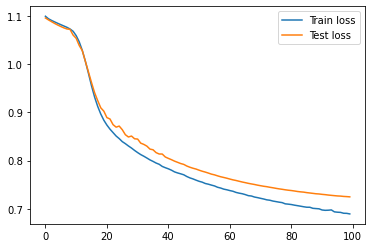

In [74]:
#plot our results
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();


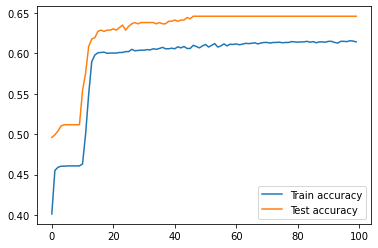

In [73]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

In [75]:
max(history.history['val_acc'])

0.6458658576011658

RNN Model history/specs

FIRST
max test accuracy 0.45553821325302124


#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(3, activation='softmax'))

#compile it
model.compile(optimizer=Adam(learning_rate=.0005), loss='CategoricalCrossentropy', metrics=['acc'])

#fit it
history = model.fit(train_sequences, validation_data=test_sequences, epochs=100, verbose=0)

notes: maxing out after 15-20 epochs 

SECOND
max test accuracy 0.4570982754230499

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(8, activation='relu'))#added and increased both hidden layers to 8
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

#compile it
model.compile(optimizer=Adam(learning_rate=.0005), loss='CategoricalCrossentropy', metrics=['acc'])

#fit it
history = model.fit(train_sequences, validation_data=test_sequences, epochs=300, verbose=0) #increased epochs from 100 to 300

notes: maxing out after 20 epochs 

THIRD
0.4586583375930786

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(32, activation='relu'))#added and increased both hidden layers to 32
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc'])

#fit it

history = model.fit(train_sequences, validation_data=test_sequences, epochs=20, verbose=0) #decreased epochs from 300 to 20


FOURTH
0.4602183997631073
added earlystopping

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(32, activation='relu'))#added and increased both hidden layers to 32
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax')) #softmax for multi-classification

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc']) #categorical crossentropy for multi-classification

#fit it
#adding early stopping as a regularization technique
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(train_sequences, validation_data=test_sequences, epochs=20, verbose=0, callbacks=[early_stop]) 

FIFTH
0.4492979645729065

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(32, activation='relu'))#added and increased both hidden layers to 32
model.add(BatchNormalization()) #added to help regularize model
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax')) #softmax for multi-classification

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc']) #categorical crossentropy for multi-classification

#fit it
#adding early stopping as a regularization technique
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(train_sequences, validation_data=test_sequences, epochs=20, verbose=0, callbacks=[early_stop]) #increased epochs from 100 to 300


SIXTH
0.4836193323135376
adding dropout 0.2

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(32, activation='relu'))#added and increased both hidden layers to 32
model.add(BatchNormalization()) #added to help regularize model
model.add(Dropout(0.2)) #added to help regularize model
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2)) #added to help regularize model
model.add(Dense(3, activation='softmax')) #softmax for multi-classification

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc']) #categorical crossentropy for multi-classification

#fit it
#adding early stopping as a regularization technique
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(train_sequences, validation_data=test_sequences, epochs=20, verbose=0, callbacks=[early_stop]) #increased epochs from 100 to 300

SEVENTH
0.4492979645729065
adding kernel regularization l1

#modeling and layers
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences= True))
model.add(GRU(8, return_sequences= False))


model.add(Dense(32, activation='relu'))#added and increased both hidden layers to 32
model.add(BatchNormalization()) #added to help regularize model
model.add(Dropout(0.2)) #added to help regularize model
model.add(Dense(32, activation='relu', kernel_regularizer='l1'))
model.add(Dropout(0.2)) #added to help regularize model
model.add(Dense(3, activation='softmax', kernel_regularizer='l1')) #softmax for multi-classification

#compile it
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['acc']) #categorical crossentropy for multi-classification

#fit it
#adding early stopping as a regularization technique
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(train_sequences, validation_data=test_sequences, epochs=20, verbose=0, callbacks=[early_stop]) #increased epochs from 100 to 300


# LSTM

In [89]:
# make df? 
X_train_lstm= np.reshape(Xs_train,(Xs_train.shape[0],1,Xs_train.shape[1]))
X_test_lstm = np.reshape(Xs_test,(Xs_test.shape[0],1,Xs_test.shape[1]))

In [92]:
X_train_lstm.shape, X_test_lstm.shape

((2920, 1, 16), (731, 1, 16))

In [93]:
# model network 

lstm = Sequential()
lstm.add(LSTM(64,input_shape=(1,16)))
lstm.add(Dense(8,activation='relu'))
lstm.add(Dense(3,activation='softmax'))

# compile model 
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

lstm.summary()

# fit model 
hist_lstm = lstm.fit(X_train_lstm,y_train, validation_data=(X_test_lstm,y_test), epochs=100,verbose=0)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 27        
Total params: 21,283
Trainable params: 21,283
Non-trainable params: 0
_________________________________________________________________


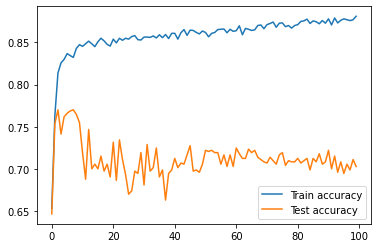

In [94]:
plot_acc(hist_lstm)

In [95]:
max(hist_lstm.history['val_acc'])

0.7701778411865234